In [22]:
# !pip install q tensorflow==2.1
# !pip install q keras==2.3.1
# !pip install git+https://github.com/qubvel/segmentation_models

# for str decode error ... run it and restart runtime
# !pip uninstall h5py -y
!pip install h5py==2.10.0

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [23]:
i = !ls Dataset/IDD/images/
l = !ls Dataset/IDD/masks/
len(i), len(l)

(5966, 5966)

In [24]:
l[-5:], i[-5:]

(['frame9980.png',
  'frame9982.png',
  'frame9991.png',
  'frame9994.png',
  'frame99992.png'],
 ['frame9980.jpg',
  'frame9982.jpg',
  'frame9991.jpg',
  'frame9994.jpg',
  'frame99992.jpg'])

In [25]:
import cv2
from glob import glob
import os
import numpy as np

# 100 = background
# 101 = road
# 102 = obstacle(person, rider, car, truck, bus, train, motorcycle, bicycle)

l = glob('Dataset/IDD/masks/*')
m = cv2.imread(l[2970],0)
m.shape
np.unique(m)


array([0, 1, 2], dtype=uint8)

In [26]:
import os
len(os.listdir('Dataset/IDD/images/')), len(os.listdir('Dataset/IDD/masks/'))

(5966, 5966)

In [27]:
import numpy as np
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_dataset(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    train_x, test_x, train_y, test_y = train_test_split(images,masks, test_size=0.1702, 
                                                        random_state=168, shuffle=True)
    return train_x, train_y, test_x, test_y

train_x, train_y, val_x, val_y = load_dataset('Dataset/IDD')
print(len(train_x), len(train_y), len(val_x), len(val_y))

4950 4950 1016 1016


### TF data API

In [28]:
train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(val_x, val_y))

In [29]:
IMG_SIZE = 512
def parse_x_y(img_path,mask_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    mask = tf.io.read_file(mask_path)    
    mask = tf.image.decode_png(mask, channels=1)  
    return {'image': image, 'segmentation_mask': mask}

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE*2))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE*2),method='nearest')    
#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.flip_left_right(input_image)
#         input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    input_mask = tf.one_hot(input_mask, 3)
    input_mask = tf.reshape(input_mask, (IMG_SIZE, IMG_SIZE*2, 3))
    return input_image, input_mask

AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 42
BATCH_SIZE = 8
BUFFER_SIZE = 2*BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.map(parse_x_y)

val_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_dataset =val_dataset.map(parse_x_y)

dataset = {"train": train_dataset, "val": val_dataset}

dataset['train'] = dataset['train'].map(
    load_image_train,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(
    load_image_train, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [30]:
for image,label in dataset['train'].take(1):
    print("image: ",image.shape)
    print("label: ",label.shape,"\n\tunique values", np.unique(label[0]))
    
for image,label in dataset['val'].take(1):
    print("image: ",image.shape)
    print("label: ",label.shape,"\n\tunique values", np.unique(label[0]))

image:  (8, 512, 1024, 3)
label:  (8, 512, 1024, 3) 
	unique values [0. 1.]
image:  (8, 512, 1024, 3)
label:  (8, 512, 1024, 3) 
	unique values [0. 1.]


In [31]:
import matplotlib.pyplot as plt

def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(7, 7))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


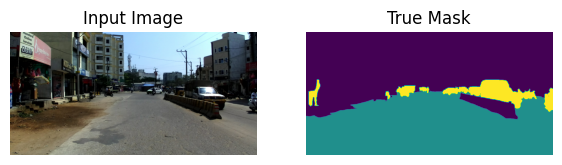

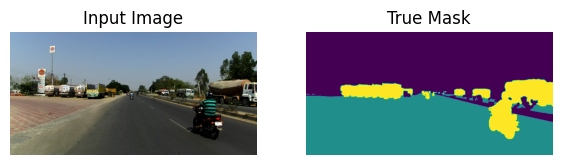

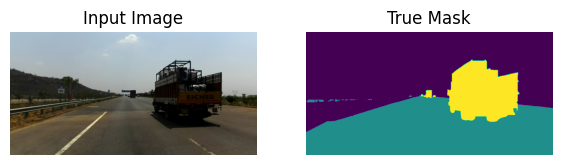

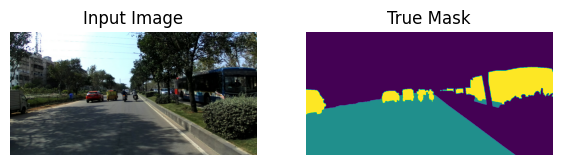

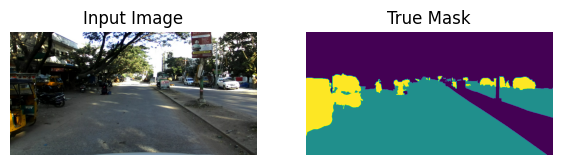

In [32]:
i=0
for image, mask in dataset['train'].take(5):
    i=i+1
#     print(i)
    sample_image, sample_mask = image, mask
    t = np.argmax(sample_mask[0],axis=-1)
    t = tf.expand_dims(t,axis=-1)
    display_sample([sample_image[0],t])

## custom data generator

In [33]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [34]:
# -*- coding: utf-8 -*-

""" Deeplabv3+ model for Keras.
This model is based on TF repo:
https://github.com/tensorflow/models/tree/master/research/deeplab
On Pascal VOC, original model gets to 84.56% mIOU
MobileNetv2 backbone is based on this repo:
https://github.com/JonathanCMitchell/mobilenet_v2_keras
# Reference
- [Encoder-Decoder with Atrous Separable Convolution
    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Xception: Deep Learning with Depthwise Separable Convolutions]
    (https://arxiv.org/abs/1610.02357)
- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for
    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"

WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "pretrained_weights/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]#.value  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same', use_bias=False,
                   name='Conv' if input_shape[2] == 3 else 'Conv_')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4_shape = tf.keras.backend.int_shape(b4)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Reshape((1, 1, b4_shape[1]))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before[1:3], interpolation="bilinear"
        )(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        skip_size = tf.keras.backend.int_shape(skip1)
        x = tf.keras.layers.experimental.preprocessing.Resizing(
                *skip_size[1:3], interpolation="bilinear"
            )(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before3[1:3], interpolation="bilinear"
        )(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
#             weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
#                                     WEIGHTS_PATH_X_CS,
#                                     cache_subdir='models')
            weights_path = "pretrained_weights/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"    
        else:
#             weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
#                                     WEIGHTS_PATH_MOBILE_CS,
#                                     cache_subdir='models')
           weights_path = "pretrained_weights/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"
            
        model.load_weights(weights_path, by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')

In [35]:
!pwd

/home/tensorflow/Documents/Semantic_Segmentation


In [36]:
# m = tf.keras.applications.MobileNet(
#     input_shape=(512,512,3),
#     alpha=1.0,
#     depth_multiplier=1,
#     dropout=0.001,
#     include_top=False,
#     weights=None,
#     input_tensor=None,
#     pooling=None,
#     classes=3,
#     classifier_activation="softmax",
# )
# m.summary()

# alpha 1.0 : 32,64,128,256,512,1024
# alpha 0.1 : 3,6,12,25,51,102
# alpha 0.3 : 9,18,36,125,153,307

m = tf.keras.applications.MobileNet(
    input_shape=(512,512,3),
    alpha=0.3,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=3,
    classifier_activation="softmax",
)
m.summary()


In [37]:
model = Deeplabv3(weights=None, input_shape=(512,512*2,3), classes=3, 
                  backbone= 'mobilenetv2', #'xception'
                  OS=16, alpha=0.3, activation='softmax')
model.load_weights('RESULTS/IDD_Dv3p_mobilenetv2_alpha0.3_bs16_3losses/ckpt_path/175.h5')

In [38]:
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
ls = dice_loss + cce_jaccard_loss #"categorical_crossentropy" 
metrics = [precision, recall, f1_score, iou_score] 

# from tensorflow.keras.models import load_model
# model = load_model('mobilenetV2_edge/ckpt_path/475.h5',
#                    custom_objects={'dice_loss_plus_categorical_crossentropy_plus_jaccard_loss':ls,
#                                    'precision':precision, 'recall':recall, 'f1-score':f1_score, 'iou_score':iou_score})

In [39]:
import os, time, keras
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Hyperparamaters """
BATCH_SIZE = 8
epochs = 1000
base_dir = 'RESULTS/IDD_Dv3p_mobilenetv2_alpha0.3_bs16_3losses_fullsizeInput'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(f"{base_dir}/ckpt_path")
    
csv_path = f"{base_dir}/history.csv"

""" callbacks """
root_logdir = os.path.join(os.curdir, f"{base_dir}/logs","fit","")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1,profile_batch='10,15')

checkpoint_filepath = f'{base_dir}/'+'ckpt_path/{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 25,
    save_best_only=False
    )
# https://keras.io/api/callbacks/lambda_callback/
# on_epoch_begin and on_epoch_end expect two positional arguments: epoch, logs
# on_batch_begin and on_batch_end expect two positional arguments: batch, logs
# on_train_begin and on_train_end expect one positional argument: logs
    
time_filepath =  f'{base_dir}/'+'epoch_time.csv'
class TimeHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times = open(time_filepath,"a")
        self.times.write(f"{epoch},{time.time() - self.epoch_time_start}\n")
        self.times.close()

time_callback = TimeHistory()
callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path, append=True),
#     EarlyStopping(monitor="val_loss", patience=10),
    time_callback,
    tensorboard_cb
]

""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

test_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    test_steps += 1

print("train_steps", train_steps, "test_steps",test_steps)

# """ Model training """
# for layer in model.layers:
#     if layer.name == "global_average_pooling2d":
#         break
#     else:
#         layer.trainable = False

# for layer in model.layers:
#     print(layer.name,layer.trainable)

model.compile(
    loss=ls,
    optimizer= "Nadam", #tf.keras.optimizers.Adam(lr),
    metrics=metrics
)
# model.summary()

env: SM_FRAMEWORK=tf.keras
train_steps 619 test_steps 127


In [ ]:
history = model.fit(
    dataset["train"],
    validation_data=dataset["val"],
    epochs=1000,
    initial_epoch = 0,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

Epoch 1/1000
619/619 [==============================] - 387s 603ms/step - loss: 0.3149 - precision: 0.9088 - recall: 0.9091 - f1-score: 0.9068 - iou_score: 0.8387 - val_loss: 0.8169 - val_precision: 0.7659 - val_recall: 0.8709 - val_f1-score: 0.7862 - val_iou_score: 0.6781
Epoch 2/1000
619/619 [==============================] - 367s 592ms/step - loss: 0.2873 - precision: 0.9173 - recall: 0.9174 - f1-score: 0.9156 - iou_score: 0.8521 - val_loss: 0.8051 - val_precision: 0.7452 - val_recall: 0.8055 - val_f1-score: 0.7601 - val_iou_score: 0.6491
Epoch 3/1000
619/619 [==============================] - 366s 591ms/step - loss: 0.2712 - precision: 0.9221 - recall: 0.9220 - f1-score: 0.9208 - iou_score: 0.8600 - val_loss: 1.2936 - val_precision: 0.8399 - val_recall: 0.6372 - val_f1-score: 0.6093 - val_iou_score: 0.5429
Epoch 4/1000
619/619 [==============================] - 365s 589ms/step - loss: 0.2546 - precision: 0.9276 - recall: 0.9267 - f1-score: 0.9263 - iou_score: 0.8683 - val_loss: 0.5

619/619 [==============================] - 365s 589ms/step - loss: 0.1329 - precision: 0.9636 - recall: 0.9625 - f1-score: 0.9630 - iou_score: 0.9300 - val_loss: 0.1833 - val_precision: 0.9510 - val_recall: 0.9479 - val_f1-score: 0.9492 - val_iou_score: 0.9059

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 59/1000
619/619 [==============================] - 363s 586ms/step - loss: 0.1331 - precision: 0.9636 - recall: 0.9624 - f1-score: 0.9629 - iou_score: 0.9299 - val_loss: 0.1816 - val_precision: 0.9519 - val_recall: 0.9483 - val_f1-score: 0.9498 - val_iou_score: 0.9070
Epoch 60/1000
619/619 [==============================] - 364s 587ms/step - loss: 0.1331 - precision: 0.9636 - recall: 0.9623 - f1-score: 0.9629 - iou_score: 0.9299 - val_loss: 0.1831 - val_precision: 0.9510 - val_recall: 0.9480 - val_f1-score: 0.9493 - val_iou_score: 0.9061
Epoch 61/1000
619/619 [==============================] - 363s 586ms/step - loss: 0.1327 - precision: 0.9639 

# STOP

In [20]:
#case2
# optimizer = 'Nadam'
# loss = 3 losses from segmentation models
# metrics = segmentation models

history = model.fit(
    dataset["train"],
    validation_data=dataset["val"],
    epochs=1000,
    initial_epoch = 0,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/1000
310/310 [==============================] - 208s 616ms/step - loss: 0.6190 - precision: 0.7983 - recall: 0.8083 - f1-score: 0.7990 - iou_score: 0.6987 - val_loss: 2.1842 - val_precision: 0.3349 - val_recall: 0.3335 - val_f1-score: 0.2558 - val_iou_score: 0.1984
Epoch 2/1000
310/310 [==============================] - 188s 606ms/step - loss: 0.4186 - precision: 0.8736 - recall: 0.8756 - f1-score: 0.8722 - iou_score: 0.7881 - val_loss: 2.2115 - val_precision: 0.3366 - val_recall: 0.3335 - val_f1-score: 0.2537 - val_iou_score: 0.1976
Epoch 3/1000
310/310 [==============================] - 185s 596ms/step - loss: 0.3678 - precision: 0.8903 - recall: 0.8917 - f1-score: 0.8892 - iou_score: 0.8122 - val_loss: 2.2960 - val_precision: 0.3391 - val_recall: 0.3335 - val_f1-score: 0.2501 - val_iou_score: 0.1961
Epoch 4/1000
310/310 [==============================] - 185s 594ms/step - loss: 0.3368 - precision: 0.9001 - recall: 0.9017 - f1-score: 0.8996 - iou_score: 0.8271 - val_loss: 2.3

Epoch 30/1000
310/310 [==============================] - 186s 599ms/step - loss: 0.2361 - precision: 0.9321 - recall: 0.9316 - f1-score: 0.9317 - iou_score: 0.8766 - val_loss: 0.2686 - val_precision: 0.9227 - val_recall: 0.9218 - val_f1-score: 0.9219 - val_iou_score: 0.8611
Epoch 31/1000
310/310 [==============================] - 185s 596ms/step - loss: 0.2359 - precision: 0.9322 - recall: 0.9317 - f1-score: 0.9318 - iou_score: 0.8767 - val_loss: 0.2673 - val_precision: 0.9232 - val_recall: 0.9227 - val_f1-score: 0.9226 - val_iou_score: 0.8621
Epoch 32/1000
310/310 [==============================] - 185s 596ms/step - loss: 0.2363 - precision: 0.9320 - recall: 0.9318 - f1-score: 0.9317 - iou_score: 0.8765 - val_loss: 0.2670 - val_precision: 0.9229 - val_recall: 0.9228 - val_f1-score: 0.9225 - val_iou_score: 0.8620
Epoch 33/1000
310/310 [==============================] - 185s 597ms/step - loss: 0.2359 - precision: 0.9320 - recall: 0.9319 - f1-score: 0.9317 - iou_score: 0.8766 - val_loss:

310/310 [==============================] - 185s 596ms/step - loss: 0.2355 - precision: 0.9325 - recall: 0.9316 - f1-score: 0.9318 - iou_score: 0.8768 - val_loss: 0.2674 - val_precision: 0.9237 - val_recall: 0.9222 - val_f1-score: 0.9226 - val_iou_score: 0.8623
Epoch 87/1000
310/310 [==============================] - 185s 595ms/step - loss: 0.2354 - precision: 0.9323 - recall: 0.9319 - f1-score: 0.9318 - iou_score: 0.8769 - val_loss: 0.2673 - val_precision: 0.9240 - val_recall: 0.9224 - val_f1-score: 0.9228 - val_iou_score: 0.8623
Epoch 88/1000
310/310 [==============================] - 184s 593ms/step - loss: 0.2350 - precision: 0.9325 - recall: 0.9320 - f1-score: 0.9320 - iou_score: 0.8771 - val_loss: 0.2670 - val_precision: 0.9242 - val_recall: 0.9224 - val_f1-score: 0.9229 - val_iou_score: 0.8625
Epoch 89/1000
310/310 [==============================] - 185s 596ms/step - loss: 0.2347 - precision: 0.9326 - recall: 0.9321 - f1-score: 0.9321 - iou_score: 0.8773 - val_loss: 0.2684 - val_

Epoch 114/1000
310/310 [==============================] - 184s 593ms/step - loss: 0.2355 - precision: 0.9325 - recall: 0.9319 - f1-score: 0.9319 - iou_score: 0.8769 - val_loss: 0.2680 - val_precision: 0.9232 - val_recall: 0.9220 - val_f1-score: 0.9223 - val_iou_score: 0.8617

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.000000032889008e-20.
Epoch 115/1000
310/310 [==============================] - 184s 593ms/step - loss: 0.2348 - precision: 0.9327 - recall: 0.9320 - f1-score: 0.9321 - iou_score: 0.8773 - val_loss: 0.2685 - val_precision: 0.9234 - val_recall: 0.9218 - val_f1-score: 0.9222 - val_iou_score: 0.8616
Epoch 116/1000
310/310 [==============================] - 185s 595ms/step - loss: 0.2363 - precision: 0.9321 - recall: 0.9315 - f1-score: 0.9316 - iou_score: 0.8765 - val_loss: 0.2664 - val_precision: 0.9241 - val_recall: 0.9224 - val_f1-score: 0.9229 - val_iou_score: 0.8626
Epoch 117/1000
310/310 [==============================] - 184s 592ms/step - loss: 0.2350 - 

Epoch 169/1000
310/310 [==============================] - 184s 594ms/step - loss: 0.2361 - precision: 0.9320 - recall: 0.9318 - f1-score: 0.9317 - iou_score: 0.8766 - val_loss: 0.2680 - val_precision: 0.9234 - val_recall: 0.9216 - val_f1-score: 0.9222 - val_iou_score: 0.8615

Epoch 00169: ReduceLROnPlateau reducing learning rate to 1.000000191250173e-31.
Epoch 170/1000
310/310 [==============================] - 184s 592ms/step - loss: 0.2349 - precision: 0.9327 - recall: 0.9319 - f1-score: 0.9321 - iou_score: 0.8772 - val_loss: 0.2678 - val_precision: 0.9237 - val_recall: 0.9221 - val_f1-score: 0.9225 - val_iou_score: 0.8618
Epoch 171/1000
310/310 [==============================] - 184s 591ms/step - loss: 0.2353 - precision: 0.9324 - recall: 0.9319 - f1-score: 0.9319 - iou_score: 0.8770 - val_loss: 0.2666 - val_precision: 0.9240 - val_recall: 0.9228 - val_f1-score: 0.9230 - val_iou_score: 0.8628
Epoch 172/1000
310/310 [==============================] - 185s 595ms/step - loss: 0.2349 - 

KeyboardInterrupt: 

In [20]:

#case1
# optimizer = 'Nadam'
# loss = keras cce
# metrics = segmentation models

history = model.fit(
    dataset["train"],
    validation_data=dataset["val"],
    epochs=1000,
    initial_epoch = 0,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

Epoch 1/1000


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


310/310 [==============================] - 209s 618ms/step - loss: 0.2977 - precision: 0.7194 - recall: 0.7236 - f1-score: 0.7184 - iou_score: 0.6099 - val_loss: 1.1649 - val_precision: 0.3340 - val_recall: 0.3336 - val_f1-score: 0.2973 - val_iou_score: 0.2133
Epoch 2/1000
310/310 [==============================] - 187s 604ms/step - loss: 0.1915 - precision: 0.8095 - recall: 0.8139 - f1-score: 0.8091 - iou_score: 0.7074 - val_loss: 1.1056 - val_precision: 0.3350 - val_recall: 0.3341 - val_f1-score: 0.3039 - val_iou_score: 0.2157
Epoch 3/1000
310/310 [==============================] - 188s 607ms/step - loss: 0.1637 - precision: 0.8359 - recall: 0.8404 - f1-score: 0.8360 - iou_score: 0.7403 - val_loss: 1.2477 - val_precision: 0.3361 - val_recall: 0.3342 - val_f1-score: 0.2895 - val_iou_score: 0.2108
Epoch 4/1000
310/310 [==============================] - 187s 602ms/step - loss: 0.1461 - precision: 0.8525 - recall: 0.8566 - f1-score: 0.8529 - iou_score: 0.7623 - val_loss: 1.2328 - val_pre

Epoch 30/1000
310/310 [==============================] - 186s 598ms/step - loss: 0.0935 - precision: 0.9030 - recall: 0.9059 - f1-score: 0.9041 - iou_score: 0.8341 - val_loss: 0.1095 - val_precision: 0.8986 - val_recall: 0.8950 - val_f1-score: 0.8965 - val_iou_score: 0.8227
Epoch 31/1000
310/310 [==============================] - 188s 606ms/step - loss: 0.0935 - precision: 0.9033 - recall: 0.9060 - f1-score: 0.9043 - iou_score: 0.8343 - val_loss: 0.1094 - val_precision: 0.8990 - val_recall: 0.8961 - val_f1-score: 0.8973 - val_iou_score: 0.8236
Epoch 32/1000
310/310 [==============================] - 185s 595ms/step - loss: 0.0935 - precision: 0.9034 - recall: 0.9062 - f1-score: 0.9044 - iou_score: 0.8345 - val_loss: 0.1093 - val_precision: 0.8984 - val_recall: 0.8965 - val_f1-score: 0.8972 - val_iou_score: 0.8235
Epoch 33/1000
310/310 [==============================] - 187s 601ms/step - loss: 0.0937 - precision: 0.9027 - recall: 0.9057 - f1-score: 0.9038 - iou_score: 0.8337 - val_loss:

KeyboardInterrupt: 

In [ ]:
# !tensorboard --logdir logs --host 0.0.0.0

#case1
# optimizer = 'Nadam'
# loss = keras cce
# metrics = segmentation models

#case2
# optimizer = 'Nadam'
# loss = 3 losses from segmentation models
# metrics = segmentation models

#case3
# train with non square images size (512,512) > (512,1024)
# optimizer = 'Nadam'
# loss = 3 losses from segmentation models
# metrics = segmentation models
# pretrained model 175 epoch weights used

# other options to explore
# reduce input size 512 > 256 > 128 > 64
# increase input size 512 > 1024

#other choices
# optimizer = RMSProp optimizer with decay 0.9 and momentum 0.9; batch norm momentum 0.99,weight decay 1e-5; 
# initial learning rate 0.256 that decays by 0.97 every 2.4 epochs

In [ ]:
# use pretrained weights of this model for human parsing dataset with 2 classes and check